In [46]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam as Adam_new
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Flatten, Input
from sklearn.neural_network import MLPRegressor
import math
from pickle import dump, load
import os
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Data Perparation

In [4]:
def load_data():
    co2_url = 'CO2Data.csv'
    co2Data = pd.read_csv(co2_url)

    # Read Greenhouse Gases data
    gg_url = 'GreenhouseGasses.csv'
    ggData = pd.read_csv(gg_url)

    # Read Surface Temperature Change data
    temp_url = 'TempData.csv'
    tempData = pd.read_csv(temp_url)
    return co2Data, ggData, tempData

In [5]:
def clean_data(co2Data, ggData, tempData):
    co2Data = co2Data.fillna(co2Data.mean())
    ggData = ggData.fillna(ggData.mean())
    tempData = tempData.fillna(tempData.mean())
    co2Data.rename(columns={'year': 'Year'}, inplace=True)

    # filter dataframes to include data from 1974 to 2021 only
    ggData = ggData[(ggData['Year'] >= 1979) & (ggData['Year'] <= 2021)]
    tempData = tempData[(tempData['Year'] >= 1979) & (tempData['Year'] <= 2021)]
    co2Data = co2Data[(co2Data['Year'] >= 1979) & (co2Data['Year'] <= 2021)]

    # merge the dataframes
    df = pd.merge(ggData, tempData, on='Year')
    df = pd.merge(df, co2Data, on='Year')
    # Define a dictionary with old column names as keys and new column names as values
    rename_dict = {
        'Year': 'Year',
        'CO2': 'CO2',
        'CH4': 'Methane',
        'N2O': 'Nitrous_Oxide',
        'CFC*': 'CFCs',
        'HCFCs': 'Hydrochlorofluorocarbons',
        'HFCs*': 'Hydrofluorocarbons',
        'Total': 'Total_Greenhouse_Gases_Heat',
        'Total.1': 'Total_Greenhouse_Gases_Concentration',
        '1990 = 1': 'Increase_Since_1990',
        'change **': 'Change_In_Temperature_Since_1967',
        'Value': 'Surface_Temperature',
        'mean': 'CO2_Concentration',
        'unc': 'CO2_Uncertainty'
    }

    # Rename the columns
    df.rename(columns=rename_dict, inplace=True)
    df = df.drop(columns=['CO2_Uncertainty'])
    return df

In [6]:
co2Data, ggData, tempData = load_data()
data = clean_data(co2Data, ggData, tempData)

## Extend Data

In [5]:
def extend_df(df: pd.DataFrame, row: pd.Series):
    new_df = pd.DataFrame([row])
    df = pd.concat([df, new_df], axis=0, ignore_index=True)
    return df

def generate_data(data: pd.DataFrame, scale: int):
    new_data = pd.DataFrame(columns=data.columns)
    new_index = 0
    for ii in range(data.shape[0]-1):
        new_data = extend_df(new_data, data.iloc[ii])
        new_index += 1
        step = (data.iloc[ii + 1] - data.iloc[ii]) / scale
        for scale_indedx in range(1, scale + 1):
            new_data = extend_df(new_data, new_data.iloc[- 1] + step * scale_indedx)
    return new_data
        

In [ ]:
data_s3 = generate_data(data, 10)
# data = data_s3

## Prepare train and test sets

In [7]:
def normalize_data(data, target_variables):
        # Normalize the data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[target_variables])
    return data_scaled, scaler

In [8]:

def get_train_test_sets(data_scaled, data):
    # Define the number of time steps (lags) to consider
    time_steps = 1

    # Prepare the training data
    train_data = data_scaled[data['Year'] < 2012]
    X_train = []
    y_train = []
    for i in range(time_steps, len(train_data)):
        X_train.append(data_scaled[i - time_steps:i]) # [:, [0,3]]
        y_train.append(data_scaled[i])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Prepare the test data
    test_data = data_scaled[data['Year'] >= 2012]
    X_test = []
    y_test = []
    for i in range(0, len(test_data)):
        val=i+len(train_data)
        X_test.append(data_scaled[val - time_steps:val]) # [:, [0,3]]
        y_test.append(test_data[i])

    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, y_train, X_test, y_test

In [9]:
target_variables = ['CO2', 'Methane', 'Nitrous_Oxide', 'CFCs',
       'Hydrochlorofluorocarbons', 'Hydrofluorocarbons',
       'Total_Greenhouse_Gases_Heat', 'Total_Greenhouse_Gases_Concentration',
       'Increase_Since_1990', 'Change_In_Temperature_Since_1967', 'Surface_Temperature', 'CO2_Concentration']
# target_variables = ['CO2']
train_variables = ['CO2', 'Methane', 'Nitrous_Oxide', 'CFCs',
       'Hydrochlorofluorocarbons', 'Hydrofluorocarbons',
       'Total_Greenhouse_Gases_Heat', 'Total_Greenhouse_Gases_Concentration',
       'Increase_Since_1990', 'Change_In_Temperature_Since_1967', 'Surface_Temperature', 'CO2_Concentration']

variables_to_convert = ["CO2", "Methane", "Nitrous_Oxide", "CFCs", "Hydrochlorofluorocarbons", "Hydrofluorocarbons", "Total_Greenhouse_Gases_Heat"]

In [10]:
data_scaled, scaler = normalize_data(data, target_variables)
X_train, y_train, X_test, y_test = get_train_test_sets(data_scaled, data)

# LSTM model

In [17]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(64, activation='relu'))
# model_lstm.add(Dense(48, activation='relu'))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(len(target_variables), activation='linear'))  # Adjust the output dimension based on the number of target variables

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# Train the model
history=model_lstm.fit(X_train, y_train, epochs=500, batch_size=16, verbose=0)

In [18]:
def convert_watt_per_m2_to_joule_per_year(watt_per_m2):
    total_surface_area_earth_m2 = 5.1 * 10**14
    seconds_per_year = 60 * 60 * 24 * 365
    joules_per_year = watt_per_m2 * total_surface_area_earth_m2 * seconds_per_year
    return joules_per_year

In [57]:
def prediction(input_year, model, scaler, data, scale = 1):
    time_steps = 1
    prediction_val = []
    if input_year>2021:
        # Prepare the input data
        input_data = data[data['Year'] <= 2021]
        input_data_scaled = scaler.transform(input_data[target_variables])
        # Prepare the input sequence
        input_sequences = []
        for i in range(len(input_data_scaled) - time_steps, len(input_data_scaled)):
            input_sequences.append(input_data_scaled[i - time_steps:i])

        for year in range(2022, input_year + 1):
            for _ in range(scale):
                input_sequences_array = np.array([sequence for sequence in input_sequences if len(sequence) == time_steps])
                input_sequence_reshaped = np.reshape(input_sequences_array, (input_sequences_array.shape[0], input_sequences_array.shape[1], len(target_variables)))

                # Make predictions for the input sequence
                predictions = model.predict(input_sequence_reshaped[-1].reshape(1, time_steps, len(target_variables)).reshape(1, 12))

                # Inverse transform the predicted values
                prediction = scaler.inverse_transform(predictions)

                # Get the predicted values for the current year
                predicted_values = prediction[0]
                
                # Append the predicted values to the results
                prediction_val.append(predicted_values)
                # for variable, value in zip(target_variables, prediction_val[-1]):
                #   print(f"{variable}: {value}")
                # Update the input sequence for the next iteration
                input_sequences[0][:-1] = input_sequences[0][1:]  # Remove the first value
                input_sequences[0][-1] = np.array(predictions)  # Add predictions at the last index
    else:
        input_data = data[data['Year'] < input_year]
        input_data_scaled = scaler.transform(input_data[target_variables])
        print("h1")
        # Prepare the input sequence
        input_sequence = []
        for i in range(len(input_data_scaled) - time_steps, len(input_data_scaled)):
            input_sequence.append(input_data_scaled[i - time_steps:i])

        input_sequence = np.array(input_sequence)

        # Reshape the input sequence for LSTM (input_shape: [samples, time_steps, features])
        # input_sequence = np.reshape(input_sequence, (input_sequence.shape[0], input_sequence.shape[1], len(target_variables)))
        input_sequence = input_sequence.reshape(1, 12)

        # Make predictions for the input sequence
        print(input_sequence.shape)
        predictions = model.predict(input_sequence)

        # Inverse transform the predicted values
        prediction_val = scaler.inverse_transform(predictions)

        # Get the predicted values for the year 2022
        predicted_values = prediction_val[-1]
        # Get the predicted values for the year 2022
        predicted_values = prediction_val[-1]
    # predicted_values = [convert_watt_per_m2_to_joule_per_year(val) for val in prediction_val[-1]]
    return predicted_values

# Regression model

In [20]:
class LSRM:
    def __init__(self, coeff: np.ndarray, degree: int = 3):
        self.coeff = coeff
        self.degree = degree

    def convert_watt_per_m2_to_joule_per_year(self, watt_per_m2):
        # Constants
        total_surface_area_earth_m2 = 5.1 * 10**14  # Total surface area of the Earth in m²
        seconds_per_year = 60 * 60 * 24 * 365  # Number of seconds in a year
        # Conversion
        joules_per_year = watt_per_m2 * total_surface_area_earth_m2 * seconds_per_year
        return joules_per_year
    
    # def train()

    def predict(self, year: int):
        all_predictions = []
        for c in range(12):
            prediction = 0
            coeff = self.coeff[c]
            for index2 in range(self.degree+1):
                prediction+=coeff[len(coeff)-index2-1]*float(year)**index2
                # converted_prediction = self.convert_watt_per_m2_to_joule_per_year(prediction)
            all_predictions.append(prediction)
        return all_predictions

In [21]:
def create_lsrm(coeff: np.ndarray):
    return LSRM(coeff)

In [22]:
loaded_coefficients = load(open('coefficients.pkl', 'rb'))
model_lsrm = create_lsrm(loaded_coefficients)

# Random Forest model

In [30]:
X_train = X_train.reshape((32, 12))

In [45]:
model_rfr = RandomForestRegressor(n_estimators=10)
model_rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [46]:
model_rfr.score(X_test.reshape((12, 12)), y_test)

-5.1968058673763435

In [49]:
y_train_predict = model_rfr.predict(X_train)

In [47]:
y_test_predict = model_rfr.predict(X_test.reshape((12, 12)))

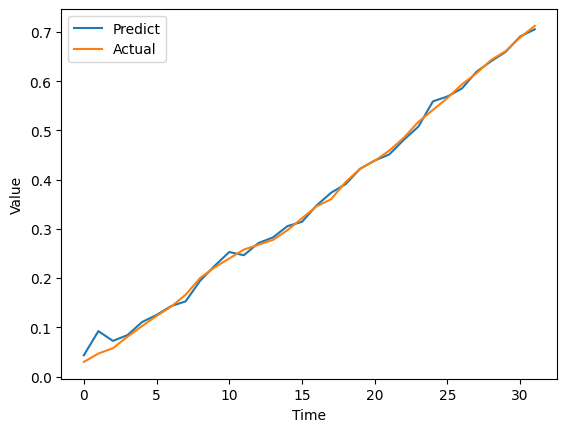

In [51]:
fig, axes = plt.subplots(1, 1)
x = [ii for ii in range(y_train_predict.shape[0])]
axes.plot(x, y_train_predict[:, 0], label='Predict')
axes.plot(x, y_train[:, 0], label='Actual')
axes.set_xlabel('Time')
axes.set_ylabel('Value')
axes.legend()

plt.show()

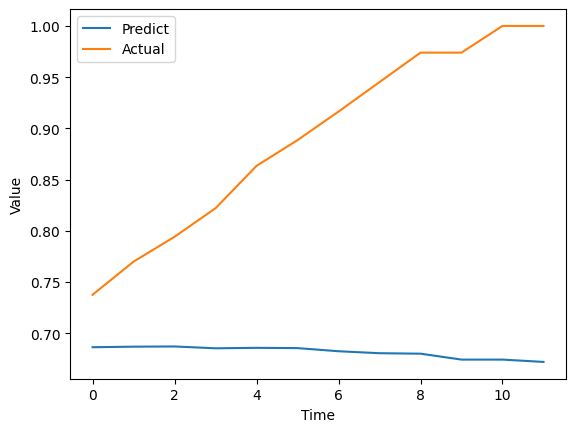

In [41]:
fig, axes = plt.subplots(1, 1)
x = [ii for ii in range(y_test_predict.shape[0])]
axes.plot(x, y_test_predict[:, 0], label='Predict')
axes.plot(x, y_test[:, 0], label='Actual')
axes.set_xlabel('Time')
axes.set_ylabel('Value')
axes.legend()

plt.show()

# ARIMA model

In [11]:
train_data = data_scaled[data['Year'] < 2012]
test_data = data_scaled[data['Year'] >= 2012]

In [12]:
train_df = pd.DataFrame(train_data, columns=target_variables)
train_df['Year'] = data.loc[data['Year'] < 2012]['Year']
train_df.index = train_df['Year']

In [13]:


def evaluate_arima_model(dataset, arima_order):
    train_size = 33
    train, test = dataset[0:train_size], dataset[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
    

In [14]:
def evaluate_models(dataset, p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					# print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	return best_cfg
	# print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [15]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
# CO2 - ARIMA(4, 1, 2)
# Methane - ARIMA(0, 2, 2)
# Nitrous_Oxide - ARIMA(6, 1, 2)
# CFCs - ARIMA(10, 1, 0)
for var_index in range(4, len(target_variables)):
    dataset_arima = data[target_variables[var_index]].values[:]
    warnings.filterwarnings("ignore")
    best_cfg = evaluate_models(dataset_arima, p_values, d_values, q_values)
    print("{} - {}".format(target_variables[var_index], best_cfg))

Hydrochlorofluorocarbons - (1, 1, 1)
Hydrofluorocarbons - (4, 0, 1)
Total_Greenhouse_Gases_Heat - (10, 0, 1)
Total_Greenhouse_Gases_Concentration - (4, 0, 1)
Increase_Since_1990 - (6, 0, 1)
Change_In_Temperature_Since_1967 - (8, 0, 1)
Surface_Temperature - (1, 1, 0)
CO2_Concentration - (1, 1, 1)


In [ ]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
for p in p_values:
		for d in d_values:
			for q in q_values:
				arima_model_prediction(p,d,q)

/Users/df/Desktop/code_source/JaiSanan_project/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/df/Desktop/code_source/JaiSanan_project/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['strat']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


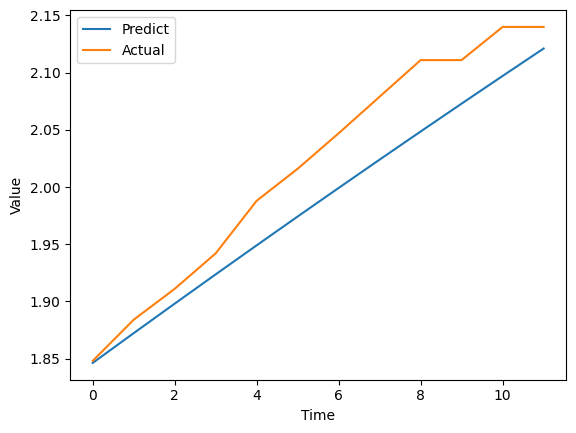

In [155]:
train_data = data.loc[data['Year']<2012]
arima_model_prediction(train_data, 1,1,1,33, 50)

In [43]:
def predict_arima(data, target_variables, start_year, end_year, train_yesr=2012):
    train_data = data.loc[data['Year']<train_yesr]
    predict_dict = {}
    start = start_year - 1979 
    end = end_year - 1979
    arima_order_dict = {
        "CO2": (4, 1, 2),
        "Methane": (0, 2, 2),
        "Nitrous_Oxide": (6, 1, 2),
        "CFCs": (10, 1, 0),
        "Hydrochlorofluorocarbons": (1, 1, 1),
        "Hydrofluorocarbons":  (4, 2, 1),
        "Total_Greenhouse_Gases_Heat": (1, 1, 1), #(10, 0, 1),
        "Total_Greenhouse_Gases_Concentration": (1, 1, 1), #(4, 0, 1),
        "Increase_Since_1990":  (1, 1, 1),#(6, 0, 1),
        "Change_In_Temperature_Since_1967": (8, 0, 1),
        "Surface_Temperature": (1, 1, 0),
        "CO2_Concentration": (1, 1, 1)
    }
    for target in target_variables:
        model = ARIMA(train_data[target], order=arima_order_dict[target])
        model_fit = model.fit()
        y_predict = model_fit.predict(strat=start, end=end)[start:end]
        predict_dict[target] = y_predict
    result_df = pd.DataFrame(predict_dict)
    result_df[variables_to_convert] = result_df[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
    return result_df


In [126]:
# y_test_predict = model_fit.predict(start=33, end=50)
# y_test_predict.values[:len(x)]
model = ARIMA(train_df['CO2'], order=(10,3,1))
model_fit = model.fit()
y_test_predict = model_fit.predict(strat=33, end=50)[33:]
# y_test_predict[33:50]
# fig, axes = plt.subplots(1, 1)
# x = [ii for ii in range(y_test.shape[0])]
# axes.plot(x, y_test_predict.values[:len(x)], label='Predict')
# axes.plot(x, y_test[:, 0], label='Actual')
# axes.set_xlabel('Time')
# axes.set_ylabel('Value')
# axes.legend()

# plt.show()

/Users/df/Desktop/code_source/JaiSanan_project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/df/Desktop/code_source/JaiSanan_project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/df/Desktop/code_source/JaiSanan_project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/df/Desktop/code_source/JaiSanan_project/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregre

In [128]:
1979 + 33

2012

In [113]:
y_test_predict = model_fit.predict(start=33, end=50)
y_test_predict.values[:len(x)]

/Users/df/Desktop/code_source/JaiSanan_project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


array([0.73612643, 0.7595986 , 0.78290644, 0.8060511 , 0.82903372,
       0.85185544, 0.87451739, 0.89702068, 0.91936642, 0.94155572,
       0.96358967, 0.98546935])

# MLPRegressor

In [110]:
model_regr = MLPRegressor(random_state=1, max_iter=500, solver='lbfgs', activation='relu', hidden_layer_sizes=(5, 6)).fit(X_train.reshape(32, 12), y_train)

# Test Models

In [23]:
start_year = 2000
end_year = 2051
lsrm_predictions = []
lstm_predictions = []
for year in range(start_year, end_year):
    lsrm_predictions.append(model_lsrm.predict(year))
    lstm_predictions.append(prediction(year, model_lstm, scaler, data, 1))



h1
1/1 [==============================] - 0s 173ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 11ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [==============================] - 0s 10ms/step
h1
1/1 [=

In [111]:
start_year = 2000
end_year = 2051
mlp_predictions = []
for year in range(start_year, end_year):
    mlp_predictions.append(prediction(year, model_regr, scaler, data, 1))

h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)
h1
(1, 12)


In [24]:
df_lsrm = pd.DataFrame(lsrm_predictions, columns=train_variables)
df_lstm = pd.DataFrame(lstm_predictions, columns=target_variables)

df_lsrm[variables_to_convert] = df_lsrm[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
df_lstm[target_variables] = df_lstm[target_variables].applymap(convert_watt_per_m2_to_joule_per_year)


In [112]:
# mlp_predictions
df_mlp = pd.DataFrame(mlp_predictions, columns=train_variables)
df_mlp[variables_to_convert] = df_mlp[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)

In [44]:
df_arima = predict_arima(data, target_variables, start_year, end_year)
# df_arima[variables_to_convert] = df_arima[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)

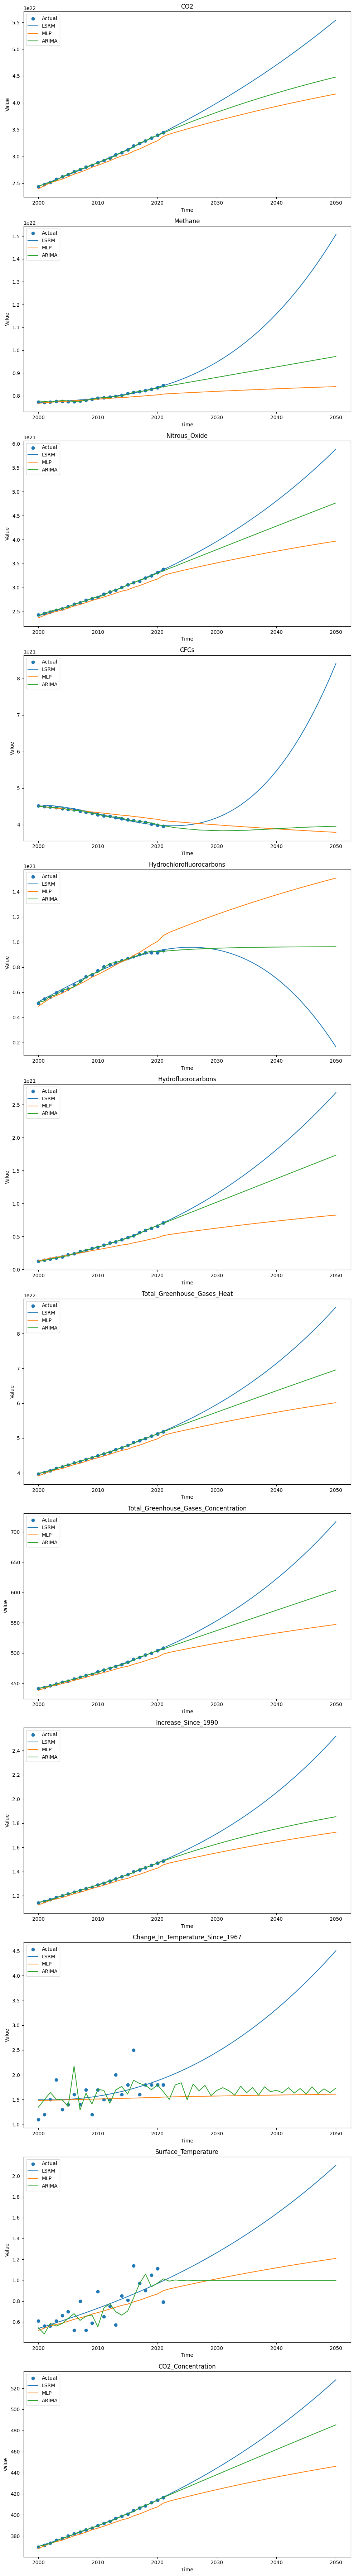

In [113]:
# Plot actual vs predicted for each target variable
fig, axes = plt.subplots(len(target_variables), 1, figsize=(10, 6 * len(target_variables)))
years = [year for year in range(start_year, end_year)]
data_to_print = data.loc[data['Year']>=start_year]
data_to_print[variables_to_convert] = data_to_print[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
for i, target_variable in enumerate(target_variables):
    axes[i].scatter(data_to_print['Year'], data_to_print[target_variable], label='Actual', marker='o')
    axes[i].plot(years, df_lsrm[target_variable], label='LSRM')
    axes[i].plot(years, df_mlp[target_variable], label='MLP')
    axes[i].plot(years, df_arima[target_variable], label='ARIMA')
    axes[i].set_title(target_variable)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:

filename = "mlp_regressor.pickle"
dump(model_regr, open(filename, "wb"))